# Detection of Simulated Attacks on a Gas Pipeline

## Context and objective

Cyberattacks pose a significant challenge within the industrial sector, with escalating costs of cybercrime and malware accompanying the proliferation of connected systems and devices. The potential ramifications of an assault on critical infrastructure are severe. Nonetheless, artificial intelligence (AI) offers a viable solution by enabling real-time data analysis and anomaly detection, thereby alerting users to potential threats. The automated detection and mitigation capabilities of AI render it an indispensable tool in contemporary society.

This capstone project focuses on analyzing data sourced from an industrial control system for a gas pipeline, detailed in the paper "Industrial Control System Network Traffic Data sets to Facilitate Intrusion Detection System Research" authored by Tommy Morris and Wei Gao. The objective is to develop a model capable of detecting and categorizing simulated attacks, while also providing insights into the utilization of artificial intelligence for mitigating cyber threats in our increasingly interconnected world.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import lightgbm as lgb

from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.tree import *

from joblib import dump, load

In [ ]:
# set up environment and connect to Google Drive
import os

from google.colab import drive

drive_root = '/content/drive'
if not os.path.exists(drive_root):
  drive.mount(drive_root)

colab_home = f'{drive_root}/MyDrive/Colab'
ws = f'{colab_home}/workspace_ucb_ml'

os.chdir(ws)

Mounted at /content/drive


## Data understanding

The data set was obtained from the [Industrial Control System (ICS) Cyber Attack Datasets](https://sites.google.com/a/uah.edu/tommy-morris-uah/ics-data-sets) website \([direct link](http://ece.uah.edu/~thm0009/icsdatasets/gas_final.arff)\) run by Tommy Morris. The data was converted from ARFF to CSV using an [online tool](https://pulipulichen.github.io/jieba-js/weka/arff2csv) developed by Pulipuli Chen.

In [ ]:
gas = pd.read_csv('data/capstone/gas_final.csv')

In [ ]:
# remove quote marks from column names
gas.rename(lambda c: c.strip('\''), axis='columns', inplace=True)

In [ ]:
# show all columns in data
pd.set_option('display.max_columns', None)

# verify data is loaded correctly
gas.head()

,id,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,comm_write_fun,resp_read_fun,resp_write_fun,sub_function,command_length,resp_length,gain,reset,deadband,cycletime,rate,setpoint,control_mode,control_scheme,pump,solenoid,crc_rate,measurement,time,result
0,1,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.528736,1.106868,0
1,2,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.043098,0
2,3,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.266332,0
3,4,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.540230,1.116280,0
4,5,4,4,183,233,9,18,3,10,3,10,0,41,19,115,0.2,0.5,1,0,20,2,1,0,0,0,0.528736,1.257916,0


### Exploratory data analysis

The data set contains the following 27 features:

* Attributes of command-response pair
  * `command_address` - device ID in command packet
  * `response_address` - device ID in reponse packet
  * `command_memory` - memory address in command packet
  * `response_memory` - memory address in reponse packet
  * `command_memory_count` - bytes in memory for read and write command
  * `response_memory_count` - bytes in memory for read and write response
  * `command_length` - length of command packet
  * `resp_length` - length of response packet
  * `time` - elapsed time between command and response
  * `crc_rate` - CRC error rate
* Packet payload attributes
  * `comm_read_function` - value of read command function code
  * `comm_write_fun` - value of write command function code
  * `resp_read_fun` - value of read response function code
  * `resp_write_fun` - value of read response function code
  * `sub_function` - value of sub-function code
  * `measurement` - pipeline pressure
  * `control_mode` - categorical variable indicating the system's control mode (0 = shutdown, 1 = manual, 2 = automatic)
  * `pump` - categorical variable indicating the pipeline's compressor state (0 = inactive, 1 = active)
* Gas pipeline attributes
  * `setpoint` - configured gas pipeline pressure
  * `control_scheme` - gas pipeline control scheme
  * `solenoid` - state of the solenoid used to control the pressure relief valve (0 = inactive, 1 = active)
  * `gain` - value of gain parameter in PID controller
  * `reset` - value of reset parameter in PID controller
  * `deadband` - value of dead gain parameter in PID controller
  * `rate` - value of rate parameter in PID controller
  * `cycletime` - value of cycle time parameter in PID controller
* Target variable
  * `result` - manual classification of the attack type (0 = not an attack)

The `id` column was automatically created during the ARFF to CSV conversion process. Because each item under `id` has a unique value, this is a non-informative feature that will be removed during the data cleaning step. Furthermore, some features in the data set did not match those described in the paper. The features that were mentioned in the paper but absent from the data set are not listed here.

In [ ]:
# drop the non-informative "id" column
gas.drop('id', axis=1, inplace=True)

In [ ]:
gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97019 entries, 0 to 97018
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   command_address        97019 non-null  int64  
 1   response_address       97019 non-null  int64  
 2   command_memory         97019 non-null  int64  
 3   response_memory        97019 non-null  int64  
 4   command_memory_count   97019 non-null  int64  
 5   response_memory_count  97019 non-null  int64  
 6   comm_read_function     97019 non-null  int64  
 7   comm_write_fun         97019 non-null  int64  
 8   resp_read_fun          97019 non-null  int64  
 9   resp_write_fun         97019 non-null  int64  
 10  sub_function           97019 non-null  int64  
 11  command_length         97019 non-null  int64  
 12  resp_length            97019 non-null  int64  
 13  gain                   97019 non-null  int64  
 14  reset                  97019 non-null  float64
 15  de

In [ ]:
gas.describe()

,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,comm_write_fun,resp_read_fun,resp_write_fun,sub_function,command_length,resp_length,gain,reset,deadband,cycletime,rate,setpoint,control_mode,control_scheme,pump,solenoid,crc_rate,measurement,time,result
count,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.0,97019.000000,97019.000000,97019.000000,97019.0,97019.000000,97019.0,9.701900e+04,97019.0,97019.0,97019.0,97019.000000,97019.000000,97019.000000,97019.000000,97019.000000,97019.0,9.701900e+04,97019.000000,97019.000000
mean,4.585226,3.719436,182.918099,216.657170,8.990012,16.737464,3.045878,10.0,2.449963,9.298591,0.016017,41.0,26.294654,115.0,2.000000e-01,0.5,1.0,0.0,24.166607,0.899659,0.992146,0.056381,0.027366,0.0,-2.772582e+34,1.139626,1.320473
std,8.951157,1.021543,3.674067,59.504855,0.282658,4.596942,0.724514,0.0,0.893052,2.553856,0.239158,0.0,26.560107,0.0,2.775572e-17,0.0,0.0,0.0,14.322356,0.991003,0.088275,0.230657,0.163148,0.0,1.818736e+36,0.091356,2.126200
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.0,1.000000,0.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,0.000000,0.000000,0.000000,0.0,-1.515320e+38,1.000000,0.000000
25%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,1.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.183908e-01,1.057822,0.000000
50%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,3.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,0.000000,1.000000,0.000000,0.000000,0.0,3.218391e-01,1.138303,0.000000
75%,4.000000,4.000000,183.000000,233.000000,9.000000,18.000000,3.000000,10.0,3.000000,10.000000,0.000000,41.0,19.000000,115.0,2.000000e-01,0.5,1.0,0.0,20.000000,2.000000,1.000000,0.000000,0.000000,0.0,5.258621e+00,1.219292,2.000000
max,249.000000,4.000000,255.000000,233.000000,9.000000,18.000000,19.000000,10.0,3.000000,10.000000,4.000000,41.0,123.000000,115.0,2.000000e-01,0.5,1.0,0.0,90.000000,2.000000,1.000000,1.000000,1.000000,0.0,2.299564e+38,1.299998,7.000000


In [ ]:
# check for duplicated data
print(f'Duplicate rows: {gas.duplicated().sum()}')

Duplicate rows: 0


In [ ]:
# get the median for measurement for later use
median_meas_static = gas['measurement'].median()

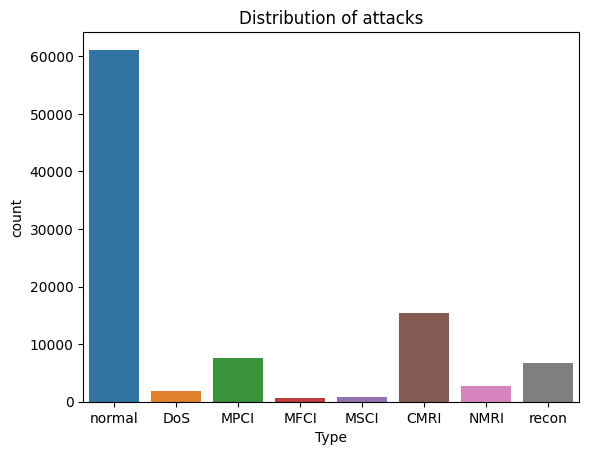

In [ ]:
# visualize attack types
attacks = {
    0: 'normal',
    1: 'NMRI',
    2: 'CMRI',
    3: 'MSCI',
    4: 'MPCI',
    5: 'MFCI',
    6: 'DoS',
    7: 'recon'
}

sns.countplot(data=gas.assign(result=gas['result'].map(attacks)), x='result', hue='result')
plt.title('Distribution of attacks')
plt.xlabel('Type')
plt.show()

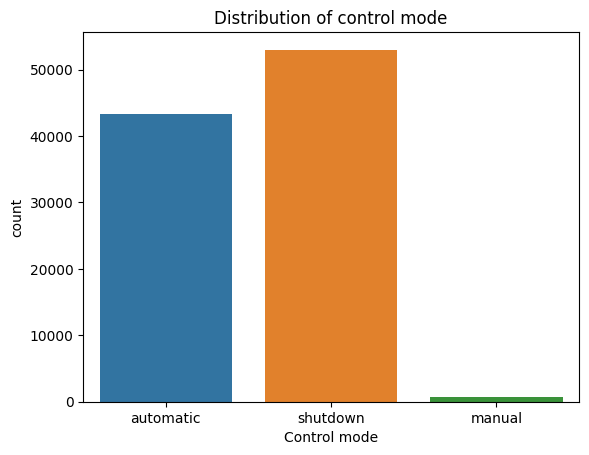

In [ ]:
# visualize control mode
control_modes = {
    0: 'shutdown',
    1: 'manual',
    2: 'automatic'
}

sns.countplot(data=gas.assign(control_mode=gas['control_mode'].map(control_modes)), x='control_mode', hue='control_mode')
plt.title('Distribution of control mode')
plt.xlabel('Control mode')
plt.show()

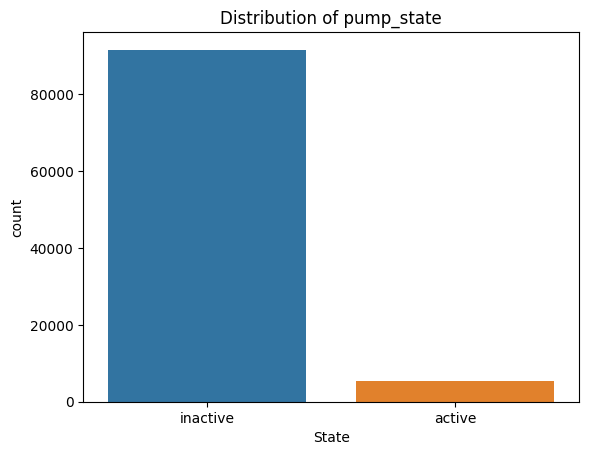

In [ ]:
# visualize pump state
pump_states = {
    0: 'inactive',
    1: 'active'
}

sns.countplot(data=gas.assign(pump=gas['pump'].map(pump_states)), x='pump', hue='pump')
plt.title('Distribution of pump_state')
plt.xlabel('State')
plt.show()

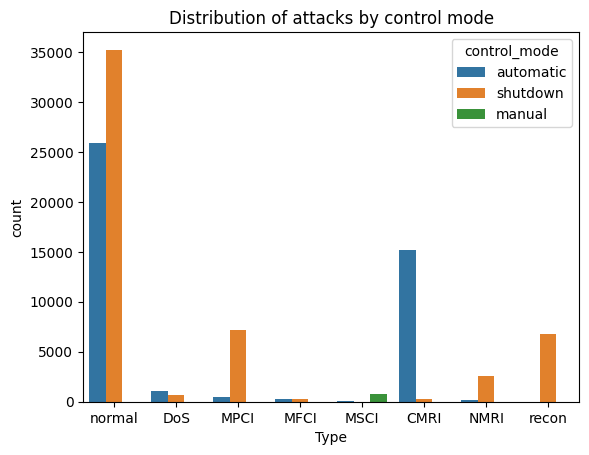

In [ ]:
sns.countplot(data=gas.assign(result=gas['result'].map(attacks), control_mode=gas['control_mode'].map(control_modes)), x='result', hue='control_mode')
plt.title('Distribution of attacks by control mode')
plt.xlabel('Type')
plt.show()

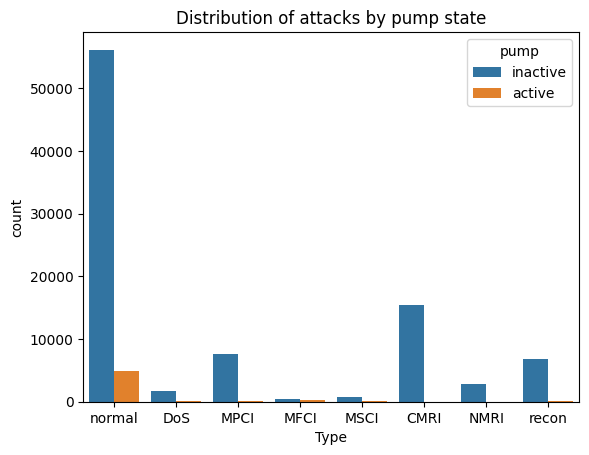

In [ ]:
sns.countplot(data=gas.assign(result=gas['result'].map(attacks), pump=gas['pump'].map(pump_states)), x='result', hue='pump')
plt.title('Distribution of attacks by pump state')
plt.xlabel('Type')
plt.show()

### Observations

* The data has no missing values or duplicate rows
* About a third of all packets are part of an attack
* A number of columns have only one unique value; these are removed as part of the data cleaning process
* The `measurement` column contains some obviously incorrect values; these are adjusted during the data pre-processing
* CMRI (complex malicious response injection) attacks were the most common
* Attacks occur more often when the pump is inactive

## Data preparation

In [ ]:
# we want only columns with more than one unique value
unique_cols = gas.min() != gas.max()
gas_clean = gas.copy()[gas.columns[gas.min() != gas.max()]]

In [ ]:
gas_clean.head()

,command_address,response_address,command_memory,response_memory,command_memory_count,response_memory_count,comm_read_function,resp_read_fun,resp_write_fun,sub_function,resp_length,setpoint,control_mode,control_scheme,pump,solenoid,measurement,time,result
0,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.528736,1.106868,0
1,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.043098,0
2,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.266332,0
3,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.540230,1.116280,0
4,4,4,183,233,9,18,3,3,10,0,19,20,2,1,0,0,0.528736,1.257916,0


It can be seen that the `measurement` column contains extreme values. Determining the cutoff point may be difficult because the source paper makes no mention of units used.\* However, the `setpoint` column has a maximum value of 90. It is therefore reasonable to assume that the pressures in the pipeline must be in the same order of magnitude. In this particular case, we replace values above 1,000 with the median.

\* An email was sent to Morris to request clarifications, but no response was received.

In [ ]:
lower_meas_limit = 0
upper_meas_limit = 1000
gas_clean['adjusted_measurement'] = gas['measurement']

bad_meas_idx = gas_clean[gas_clean['measurement'] > upper_meas_limit].index
bad_meas_idx = bad_meas_idx.union(gas_clean[gas_clean['measurement'] < lower_meas_limit].index)
gas_clean.loc[bad_meas_idx, 'adjusted_measurement'] = median_meas_static

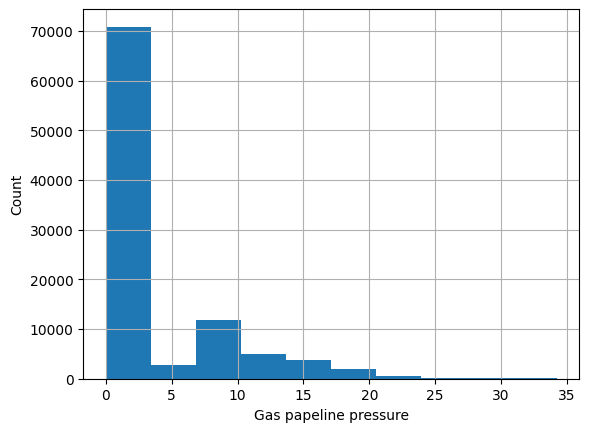

In [ ]:
gas_clean['adjusted_measurement'].hist()
plt.xlabel('Gas papeline pressure')
plt.ylabel('Count')
plt.show()

## Modeling

We now test a number of different models to determine which best fits the data.

**Note:** Testing has shown that using the original `measurement` column results in a higher accuracy for certain models. We've included an option to use the original data if so desired.

In [ ]:
use_adjusted_meas = False

if use_adjusted_meas:
  gas_clean.drop('measurement', axis=1, inplace=True)
else:
  gas_clean.drop('adjusted_measurement', axis=1, inplace=True)

In [ ]:
X = gas_clean.drop('result', axis=1)
y = gas_clean['result']

columns = X.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [ ]:
# create a function to visualize feature importance for models that support it
def feature_importance(model, features=columns):
  importances = model.feature_importances_

  importance_df = pd.DataFrame(importances, index=features, columns=['Importance']).sort_values(by='Importance', ascending=False)
  plt.figure()
  sns.barplot(x=importance_df.Importance, y=importance_df.index)
  plt.show()

### Decision trees

Decision trees are highly explainable and generally simple to train. However, they have a lower accuracy compared to other models.

In [ ]:
%%time
dt = DecisionTreeClassifier(random_state=1)
dt.fit(X_train, y_train)

CPU times: user 306 ms, sys: 0 ns, total: 306 ms
Wall time: 308 ms


DecisionTreeClassifier(random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_dt_train = dt.predict(X_train)
y_pred_dt = dt.predict(X_test)

Baseline decision tree accuracy for training data: 1.0
Baseline decision tree accuracy for test data: 0.9859822716965574


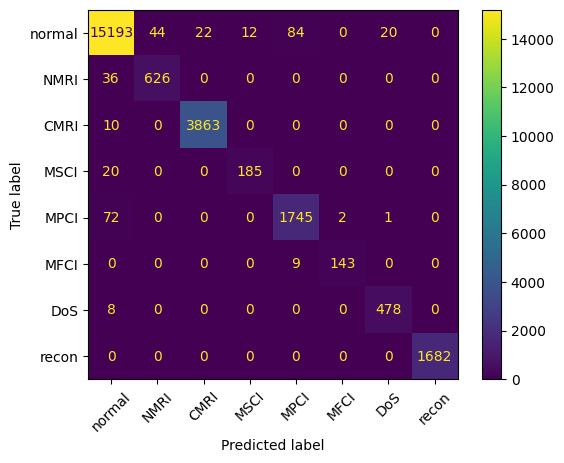

In [ ]:
print("Baseline decision tree accuracy for training data:", accuracy_score(y_train, y_pred_dt_train))
print("Baseline decision tree accuracy for test data:", accuracy_score(y_test, y_pred_dt))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(dt, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

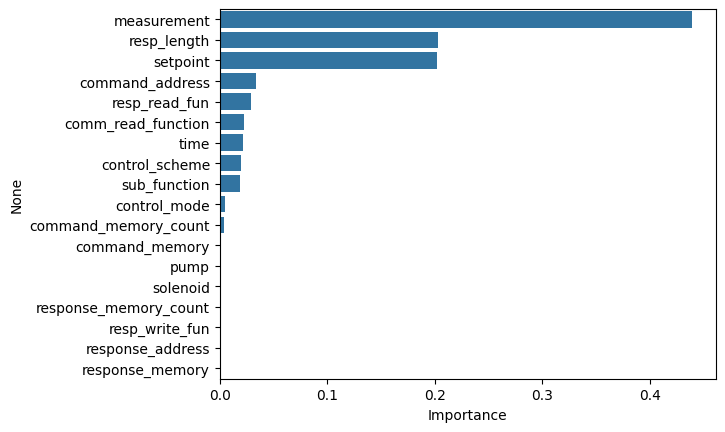

In [ ]:
feature_importance(dt)

We create a second instance that ignores the less important features as identified by the decision tree classsifier.

In [ ]:
dt_exclude_columns = [
    'command_memory',
    'pump',
    'solenoid',
    'response_memory_count',
    'resp_write_fun',
    'response_address',
    'response_memory',
    'control_mode'
]

X_train_dt_ss = X_train.drop(columns=dt_exclude_columns, axis=1)
X_test_dt_ss = X_test.drop(columns=dt_exclude_columns, axis=1)

In [ ]:
%%time
dt_ss = DecisionTreeClassifier(random_state=1)
dt_ss.fit(X_train_dt_ss, y_train)

CPU times: user 298 ms, sys: 2.87 ms, total: 301 ms
Wall time: 300 ms


DecisionTreeClassifier(random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_dt_ss_train = dt_ss.predict(X_train_dt_ss)
y_pred_dt_ss = dt_ss.predict(X_test_dt_ss)

Decision tree accuracy (excluding low-importance features) for training data: 1.0
Decision tree accuracy (excluding low-importance features) for test data: 0.9856936714079572


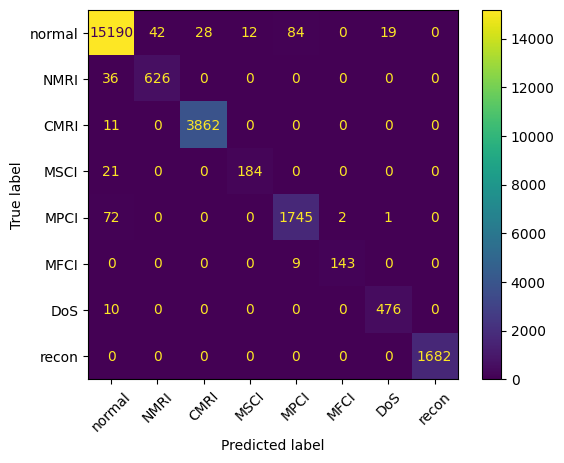

In [ ]:
print("Decision tree accuracy (excluding low-importance features) for training data:", accuracy_score(y_train, y_pred_dt_ss_train))
print("Decision tree accuracy (excluding low-importance features) for test data:", accuracy_score(y_test, y_pred_dt_ss))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(dt_ss, X_test_dt_ss, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

### Random forests

Random forests are an ensemble learning method that can be used for both classification and regression. Ensemble methods use multiple algorithms to achieve better predictive performance.

In [ ]:
%%time
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

CPU times: user 9 s, sys: 10.6 ms, total: 9.01 s
Wall time: 9.11 s


RandomForestClassifier(random_state=1)

In [ ]:
# classify the test data using the trained model
y_pred_rf_train = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

Baseline random forest accuracy for training data: 0.9991479302952009
Baseline random forest accuracy for test data: 0.9889507318078746


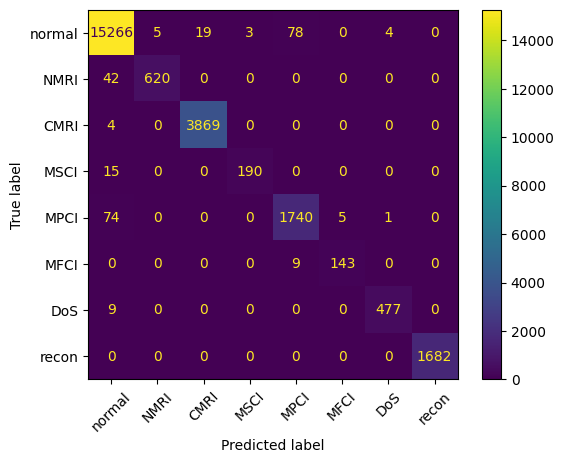

In [ ]:
print("Baseline random forest accuracy for training data:", accuracy_score(y_train, y_pred_rf_train))
print("Baseline random forest accuracy for test data:", accuracy_score(y_test, y_pred_rf))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(rf, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

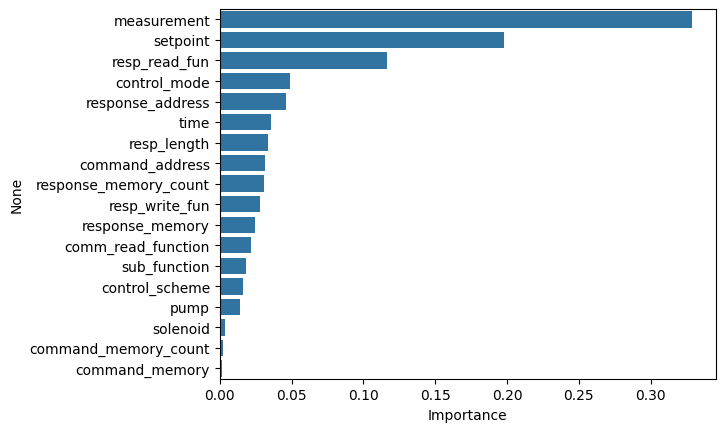

In [ ]:
feature_importance(rf)

We create a second instance that ignores the less important features as identified  by the random forest classsifier.

In [ ]:
rf_exclude_columns = [
    'solenoid',
    'command_memory',
    'response_memory_count'
]

X_train_rf_ss = X_train.drop(columns=rf_exclude_columns, axis=1)
X_test_rf_ss = X_test.drop(columns=rf_exclude_columns, axis=1)

In [ ]:
%%time
rf_ss = RandomForestClassifier(random_state=1)
rf_ss.fit(X_train_rf_ss, y_train)

CPU times: user 8.27 s, sys: 17.2 ms, total: 8.28 s
Wall time: 8.32 s


RandomForestClassifier(random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_rf_ss_train = rf_ss.predict(X_train_rf_ss)
y_pred_rf_ss = rf_ss.predict(X_test_rf_ss)

Random forest accuracy (excluding low-importance features) for training data: 0.9992029025342202
Random forest accuracy (excluding low-importance features) for test data: 0.9885384456813028


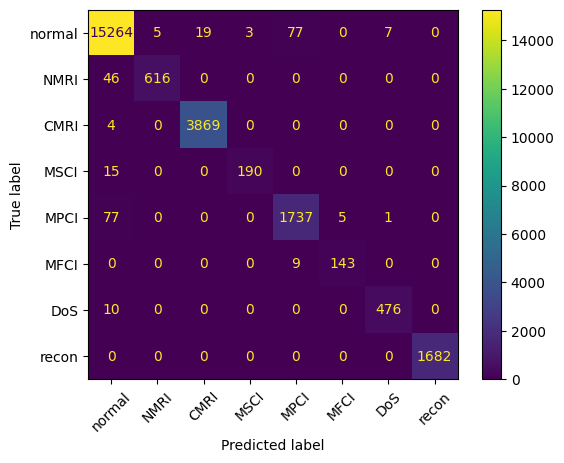

In [ ]:
print("Random forest accuracy (excluding low-importance features) for training data:", accuracy_score(y_train, y_pred_rf_ss_train))
print("Random forest accuracy (excluding low-importance features) for test data:", accuracy_score(y_test, y_pred_rf_ss))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(rf_ss, X_test_rf_ss, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

### Gradient boosting classifier

Gradient-boosting trees are potentially more accurate than random forests because the algorithm tries to correct errors in the previous tree. However, gradient boosting is more prone to overfitting and cannot be trained in parallel. We use histogram-based gradient-boosting classification as it is more suitable for larger data sets (say *n* > 10,000) than the regular gradient-boosting classifier.

In [ ]:
%%time
gbc = HistGradientBoostingClassifier(random_state=1)
gbc.fit(X_train, y_train)

CPU times: user 2.67 s, sys: 37.2 ms, total: 2.71 s
Wall time: 1.46 s


HistGradientBoostingClassifier(random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_gbc_train = gbc.predict(X_train)
y_pred_gbc = gbc.predict(X_test)

Baseline gradient-boosting classifier accuracy for training data: 0.990792149964268
Baseline gradient-boosting classifier accuracy for test data: 0.9904349618635333


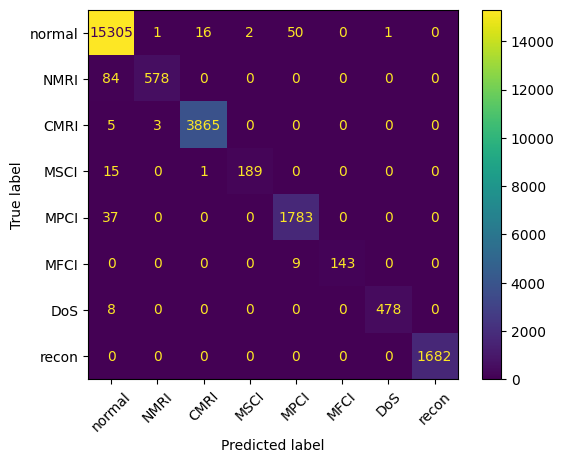

In [ ]:
print("Baseline gradient-boosting classifier accuracy for training data:", accuracy_score(y_train, y_pred_gbc_train))
print("Baseline gradient-boosting classifier accuracy for test data:", accuracy_score(y_test, y_pred_gbc))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

**Note:** Unlike regular gradient-boosting classifiers, histogram-based gradient-boosting classifiers do not have an attribute for the ranking of features.

### LightGBM

LightGBM is a gradient-boosting machine developed by Microsoft that focuses on performance and scalability.

In [ ]:
%%time
lgbm = lgb.LGBMClassifier(force_row_wise=True, random_state=1)
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Total Bins 700
[LightGBM] [Info] Number of data points in the train set: 72764, number of used features: 18
[LightGBM] [Info] Start training from score -0.463352
[LightGBM] [Info] Start training from score -3.544808
[LightGBM] [Info] Start training from score -1.836820
[LightGBM] [Info] Start training from score -4.837134
[LightGBM] [Info] Start training from score -2.526437
[LightGBM] [Info] Start training from score -5.152344
[LightGBM] [Info] Start training from score -3.986376
[LightGBM] [Info] Start training from score -2.653481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: user 4.61 s, sys: 73.2 ms, total: 4.68 s
Wall time: 4.68 s


LGBMClassifier(force_row_wise=True, random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_lgbm_train = lgbm.predict(X_train)
y_pred_lgbm = lgbm.predict(X_test)

Baseline LightGBM accuracy for training data: 0.9943516024407674
Baseline LightGBM accuracy for test data: 0.989940218511647


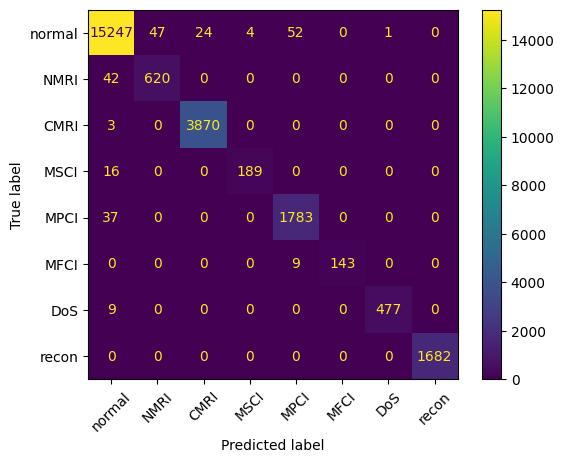

In [ ]:
print("Baseline LightGBM accuracy for training data:", accuracy_score(y_train, y_pred_lgbm_train))
print("Baseline LightGBM accuracy for test data:", accuracy_score(y_test, y_pred_lgbm))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

### Observations

* All four models gave very high predictive performance. Out of those four models, the histogram-based gradient-boosting machine had the highest accuracy
* For the decision tree and random forest classifiers, dropping low-importance features resulted in a very slight drop in accuracy but did not significantly affect the time needed to train the models
* Both the decision tree and random forest classifiers had 100% accuracy for the training data as well as a high accuracy for the test data. This suggests there is a clear pattern in the data as opposed to overfitting
* LightGBM had the second-best accuracy and a run time comparable to that of the histogram-based gradient-boosting machine

## Evaluation

We now evaluate and further improve the optimal classifier, the histogram-based gradient boosting machine in this case. In a real-world scenario, the objective should be to detect as many attacks as possible; this would require us to optimize the recall or F<sub>1</sub> score. However, because this particular data set is fairly balanced if the data is split into attacks and non-attacks, we will use the accuracy score for this exercuse.

In [ ]:
gbc_params = {
    'max_iter': [100, 500, 1000],
    'learning_rate': [0.1, 0.5],
    'max_depth': [25, 50]
}

gbc_grid_saved = 'gbc_optimal.joblib'
gbc_grid_path = f'data/capstone/saved_models/{gbc_grid_saved}'

if os.path.isfile(gbc_grid_path):
  print(f'Found existing saved model: {gbc_grid_saved}\n')
  gbc_grid = load(gbc_grid_path)
else:
  gbc_grid = GridSearchCV(gbc, param_grid=gbc_params, cv=5)
  gbc_grid.fit(X_train, y_train)
  dump(gbc_grid, gbc_grid_path)

gbc_grid

Found existing saved model: gbc_optimal.joblib



GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=1),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [25, 50],
                         'max_iter': [100, 500, 1000]})

In [ ]:
gbc_grid.best_estimator_

HistGradientBoostingClassifier(max_depth=25, random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_gbc_optimal_train = gbc_grid.predict(X_train)
y_pred_gbc_optimal = gbc_grid.predict(X_test)

Training accuracy of optimal gradient-boosting model: 0.990792149964268
Test accuracy of optimal gradient-boosting model: 0.9904349618635333


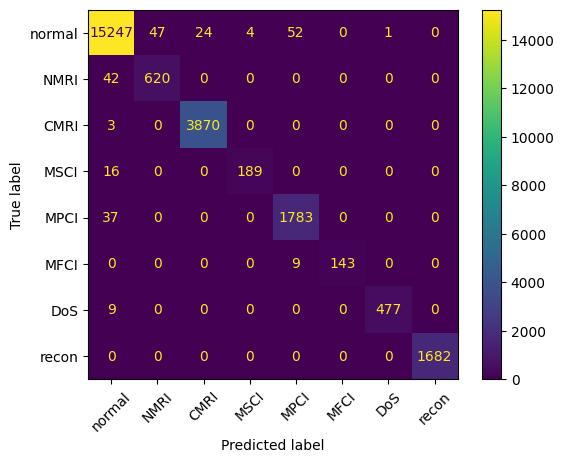

In [ ]:
print("Training accuracy of optimal gradient-boosting model:", accuracy_score(y_train, y_pred_gbc_optimal_train))
print("Test accuracy of optimal gradient-boosting model:", accuracy_score(y_test, y_pred_gbc_optimal))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgbm, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

In [ ]:
lgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1],
    'num_leaves': [15, 31, 63]
}

lgb_grid_saved = 'lgb_optimal.joblib'
lgb_grid_path = f'data/capstone/saved_models/{lgb_grid_saved}'

if os.path.isfile(lgb_grid_path):
  print(f'Found existing saved model: {lgb_grid_saved}\n')
  lgb_grid = load(lgb_grid_path)
else:
  lgb_grid = GridSearchCV(lgbm, param_grid=lgb_params, cv=5)
  lgb_grid.fit(X_train, y_train)
  dump(lgb_grid, lgb_grid_path)

lgb_grid

Found existing saved model: lgb_optimal.joblib



GridSearchCV(cv=5,
             estimator=LGBMClassifier(force_row_wise=True, random_state=1),
             param_grid={'learning_rate': [0.1, 0.5, 1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [15, 31, 63]})

In [ ]:
lgb_grid.best_estimator_

LGBMClassifier(force_row_wise=True, n_estimators=50, num_leaves=15,
               random_state=1)

In [ ]:
# classify the data using the trained model
y_pred_lgb_optimal_train = lgb_grid.predict(X_train)
y_pred_lgb_optimal = lgb_grid.predict(X_test)

Training accuracy of optimal LightGBM model: 0.9921114837007311
Test accuracy of optimal LightGBM model: 0.9904349618635333


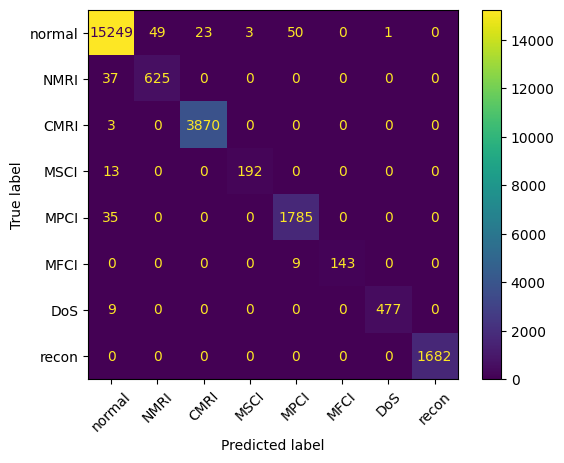

In [ ]:
print("Training accuracy of optimal LightGBM model:", accuracy_score(y_train, y_pred_lgb_optimal_train))
print("Test accuracy of optimal LightGBM model:", accuracy_score(y_test, y_pred_lgb_optimal))

# display confusion matrix
ConfusionMatrixDisplay.from_estimator(lgb_grid, X_test, y_test, display_labels=list(attacks.values()), xticks_rotation=45)
plt.show()

### Observations

* Hyperparameter tuning did not result in an improvement for the histogram-based gradient boosting machine
* LightGBM had a slight increase in test accuracy but a small drop in training accuracy
* The optimized gradient-boosting machine and LightGBM had the exact same test accuracy

## Business insights and recommendations

### Findings

* Four models were used in this exercise: decision trees, random forests, histogram-based gradient-boosting machines and LightGBM. All four models used had high predictive performance. However, this may be because the data set is fairly balanced. As this is not necessarily the case in real-world environments, additional measures may be needed to account for unbalanced data
* Based on performance metrics and run time, either the histogram-based gradient-boosting machine or LightGBM could be selected as the model of choice
* The above two models were selected for further optmization. Both models yielded the exact same accuracy score after hyperparameter tuning
* Experimentation has shown that the original data with outliers yielded a higher accuracy for all models. This is likely because the invalid values are indicative of an attack

### Recommendations

* In a real-world scenario, false negatives can be costly compared to misclassifying legitimate traffic. Attack detection models used in production should be optimized for recall or F<sub>1</sub> score rather than accuracy
* Hyperparameter tuning was only performed on a small set of parameters due to time constraints. In real-world situations, a larger set of parameters should ideally be used to maximize predictive performance
* Detection of a real cyber attack may not be as straightforward as in this capstone project because bad actors will often attempt to make their attacks as difficult to detect as possible. An attack detection model intended for production use should be trained on much larger data sets
* The time required to make a prediction should also be taken into consideration when selecting a model. Otherwise, a threat detection system may not be able to provide real-time protection when there is high traffic